In [1]:
# Import libraries
import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# # Method 1: Upload files manually
# from google.colab import files
# uploaded = files.upload()

# # Method 2: Mount Google Drive (Recommended)
# from google.colab import drive
# drive.mount('/content/drive')

# Read CSV files directly with DuckDB
conn = duckdb.connect(':memory:')

# Load data directly from CSV (DuckDB can read CSV efficiently)
df_ecommerce = pd.read_csv(r'd:\ds-takehome-test\data\e_commerce_transactions.csv')
# df_credit = pd.read_csv('/content/credit_scoring.csv')

print("Data loaded successfully!")
print(f"E-commerce data shape: {df_ecommerce.shape}")
# print(f"Credit data shape: {df_credit.shape}")

Data loaded successfully!
E-commerce data shape: (10000, 6)


In [6]:
# Register DataFrames as views in DuckDB
conn.register('e_commerce_transactions', df_ecommerce)
# conn.register('credit_scoring', df_credit)

# Verify tables
tables = conn.execute("SHOW TABLES").fetchall()
print("Available tables:", tables)

# Check data
print("\nE-commerce sample:")
print(conn.execute("SELECT * FROM e_commerce_transactions LIMIT 5").df())

Available tables: [('e_commerce_transactions',)]

E-commerce sample:
   order_id  customer_id  order_date  payment_value decoy_flag  decoy_noise
0    101000          684  2024-01-29          38.93          A        39.51
1    101001          207  2024-06-29          59.52          B        38.97
2    101002          288  2024-03-20         355.52          B       338.14
3    101003          571  2024-02-24         157.65          C       121.69
4    101004          871  2024-01-11         287.68          C       254.92


RFM Analysis

In [7]:
query_rfm = """
WITH rfm_metrics AS (
  SELECT
    customer_id,
    MAX(order_date) AS last_order_date,
    COUNT(order_id) AS frequency,
    SUM(payment_value) AS monetary,
    DATEDIFF('day', MAX(order_date::DATE), DATE '2025-05-06') AS recency
  FROM e_commerce_transactions
  GROUP BY customer_id
),
rfm_scores AS (
  SELECT *,
    NTILE(5) OVER (ORDER BY recency) AS r_score,
    NTILE(5) OVER (ORDER BY frequency) AS f_score,
    NTILE(5) OVER (ORDER BY monetary) AS m_score
  FROM rfm_metrics
),
rfm_segments AS (
  SELECT
    customer_id,
    recency,
    frequency,
    monetary,
    r_score,
    f_score,
    m_score,
    CASE
      WHEN r_score <= 2 AND f_score >= 4 AND m_score >= 4 THEN 'Champions'
      WHEN r_score <= 2 AND f_score >= 3 THEN 'Loyal Customers'
      WHEN r_score <= 3 AND f_score >= 2 AND m_score >= 2 THEN 'Potential Loyalists'
      WHEN r_score >= 4 AND f_score >= 3 THEN 'At Risk'
      WHEN r_score >= 4 AND f_score <= 2 AND m_score >= 3 THEN 'Cannot Lose Them'
      WHEN r_score = 5 AND f_score <= 2 AND m_score <= 2 THEN 'Lost Customers'
      WHEN r_score BETWEEN 3 AND 4 AND f_score BETWEEN 2 AND 3 THEN 'Need Attention'
      ELSE 'Others'
    END AS customer_segment
  FROM rfm_scores
)
SELECT *
FROM rfm_segments
ORDER BY customer_id;
"""

# 🔄 Execute Query
rfm_result = conn.execute(query_rfm).df()

# 🔍 Tampilkan hasil
print("RFM Segmentation Results:")
print(rfm_result.head(10))

print(f"\nTotal customers: {len(rfm_result)}")

print("\n Segment Distribution:")
segment_dist = rfm_result['customer_segment'].value_counts()
print(segment_dist)

print("\n Segment Percentages:")
print((segment_dist / len(rfm_result) * 100).round(2))

RFM Segmentation Results:
   customer_id  recency  frequency  monetary  r_score  f_score  m_score  \
0            1      433          6    517.09        5        1        1   
1            2      411         14   3198.96        5        5        5   
2            3      198         10   1892.63        1        3        3   
3            4      390          9   1232.10        5        3        1   
4            5      288         12   3372.05        2        4        5   
5            6      181         12   1861.54        1        4        3   
6            7      312          9   1406.79        2        2        2   
7            8      303         11   2902.49        2        4        5   
8            9      412          7   1270.03        5        2        1   
9           10      201         15   3408.68        1        5        5   

      customer_segment  
0       Lost Customers  
1              At Risk  
2      Loyal Customers  
3              At Risk  
4            Champions 

In [8]:
print("RFM Segmentation Results (Sorted by R_Score - Highest First):")
print(rfm_result.sort_values('recency', ascending=False).head(10))

RFM Segmentation Results (Sorted by R_Score - Highest First):
     customer_id  recency  frequency  monetary  r_score  f_score  m_score  \
941          942      481          4    629.73        5        1        1   
577          578      464          3    353.33        5        1        1   
733          734      462          6   1209.48        5        1        1   
518          519      460          6   1336.99        5        1        2   
929          930      455          9   2374.23        5        3        4   
436          437      455          6   1098.12        5        1        1   
366          367      453          7   1426.79        5        2        2   
635          636      446          2    558.21        5        1        1   
803          804      444          3    525.96        5        1        1   
468          469      443          7    971.27        5        2        1   

    customer_segment  
941   Lost Customers  
577   Lost Customers  
733   Lost Customers 

Anomaly Detection

In [ ]:
query_anomaly = """WITH p99 AS (
  SELECT PERCENTILE_CONT(0.99) WITHIN GROUP (ORDER BY payment_value) AS val
  FROM e_commerce_transactions
)
SELECT
  order_id,
  customer_id,
  payment_value,
  decoy_flag,
  decoy_noise,
  CASE
    WHEN decoy_noise > 500 OR decoy_noise < -500 THEN 'Anomaly_Noise'
    WHEN decoy_flag NOT IN ('A', 'B', 'C', 'D') THEN 'Anomaly_Flag'
    WHEN payment_value > (SELECT val FROM p99) THEN 'Anomaly_Payment'
    ELSE 'Normal'
  END AS anomaly_type,
  CASE
    WHEN decoy_noise > 500 OR decoy_noise < -500 THEN 'Noise out of range'
    WHEN decoy_flag NOT IN ('A', 'B', 'C', 'D') THEN 'Invalid flag'
    WHEN payment_value > (SELECT val FROM p99) THEN 'Outlier payment value (> P99)'
    ELSE 'No anomaly'
  END AS anomaly_reason
FROM e_commerce_transactions
WHERE
  decoy_noise > 500 OR decoy_noise < -500
  OR decoy_flag NOT IN ('A', 'B', 'C', 'D')
  OR payment_value > (SELECT val FROM p99)
ORDER BY decoy_noise DESC
"""
# Eksekusi query
anomaly_result = conn.execute(query_anomaly).df()

# Tambahkan multiple anomaly audit
def detect_multiple_anomalies(row, p99_val):
    reasons = []
    if abs(row['decoy_noise']) > 500:
        reasons.append('Noise')
    if row['decoy_flag'] not in ['A', 'B', 'C', 'D']:
        reasons.append('Flag')
    if row['payment_value'] > p99_val:
        reasons.append('Payment')
    return ', '.join(reasons)

# Hitung P99 satu kali saja
p99_val = anomaly_result['payment_value'].quantile(0.99)
anomaly_result['anomaly_flags'] = anomaly_result.apply(lambda row: detect_multiple_anomalies(row, p99_val), axis=1)

# Tampilkan hasil awal
print("Anomaly Detection Results:")
print(anomaly_result.head(10))
print(f"\nTotal anomalies found: {len(anomaly_result)}")

# Distribusi anomaly
print("\nAnomaly types distribution:")
print(anomaly_result['anomaly_type'].value_counts())

# Statistik detail tiap tipe anomaly
for anomaly_type in ['Anomaly_Noise', 'Anomaly_Flag', 'Anomaly_Payment']:
    subset = anomaly_result[anomaly_result['anomaly_type'] == anomaly_type]
    if not subset.empty:
        print(f"\n{anomaly_type} stats:")
        print(f"  - Count: {len(subset)}")
        if anomaly_type == 'Anomaly_Noise':
            print(f"  - Noise Range: {subset['decoy_noise'].min()} to {subset['decoy_noise'].max()}")
        elif anomaly_type == 'Anomaly_Flag':
            print(f"  - Flags found: {subset['decoy_flag'].unique()}")
        elif anomaly_type == 'Anomaly_Payment':
            print(f"  - Payment Range: {subset['payment_value'].min()} to {subset['payment_value'].max()}")

# # Simpan ke CSV
# anomaly_result.to_csv("anomaly_detection_results.csv", index=False)
# print("\nAnomaly results exported to 'anomaly_detection_results.csv'")


Anomaly Detection Results:
   order_id  customer_id  payment_value decoy_flag  decoy_noise  \
0    107006          501        1369.47          B      1468.46   
1    110717          930        1021.76          C      1170.73   
2    109909          880         947.08          A      1153.43   
3    103012          309         967.38          C      1144.52   
4    109462           16         988.11          B      1095.57   
5    110822          521         913.93          A      1088.74   
6    104854           22         861.75          C      1041.10   
7    107161          763         817.19          C      1011.15   
8    101151          408         928.50          B       995.56   
9    107401          379         847.07          C       984.28   

    anomaly_type      anomaly_reason   anomaly_flags  
0  Anomaly_Noise  Noise out of range  Noise, Payment  
1  Anomaly_Noise  Noise out of range  Noise, Payment  
2  Anomaly_Noise  Noise out of range  Noise, Payment  
3  Anomaly_Nois

Repeat Purchase Analysis

In [ ]:
query_repeat = """
WITH monthly_customers AS (
  SELECT
    DATE_TRUNC('month', order_date::DATE) as month,
    customer_id,
    COUNT(order_id) as orders_count
  FROM e_commerce_transactions
  GROUP BY DATE_TRUNC('month', order_date::DATE), customer_id
)
SELECT
  month,
  COUNT(DISTINCT customer_id) as total_customers,
  COUNT(DISTINCT CASE WHEN orders_count > 1 THEN customer_id END) as repeat_customers,
  ROUND(COUNT(DISTINCT CASE WHEN orders_count > 1 THEN customer_id END) * 100.0 / COUNT(DISTINCT customer_id), 2) as repeat_rate_percent
FROM monthly_customers
GROUP BY month
ORDER BY month
"""

repeat_result = conn.execute(query_repeat).df()
print("Monthly Repeat Purchase Analysis:")
print(repeat_result)

Monthly Repeat Purchase Analysis:
        month  total_customers  repeat_customers  repeat_rate_percent
0  2024-01-01              980               921                93.98
1  2024-02-01              895               670                74.86
2  2024-03-01              763               440                57.67
3  2024-04-01              563               201                35.70
4  2024-05-01              388                92                23.71
5  2024-06-01              283                48                16.96
6  2024-07-01              174                19                10.92
7  2024-08-01               96                 6                 6.25
8  2024-09-01               60                 3                 5.00
9  2024-10-01               31                 1                 3.23
10 2024-11-01               22                 0                 0.00
11 2024-12-01               17                 0                 0.00
12 2025-01-01                6                 0        

In [14]:
# 📥 Load file analysis.sql
with open("D:/ds-takehome-test/analysis.sql", "r") as f:
    full_sql = f.read()

# Fungsi untuk ambil query berdasarkan tag
def extract_query(tag):
    sections = full_sql.split('--tag:')
    for section in sections:
        if section.strip().startswith(tag):
            return section.split('--tag:')[0].strip()
    return None

# Eksekusi masing-masing query
query_rfm = extract_query("rfm_query")
rfm_result = conn.execute(query_rfm).df()

query_anomaly = extract_query("anomaly_query")
anomaly_result = conn.execute(query_anomaly).df()

query_repeat = extract_query("repeat_query")
repeat_result = conn.execute(query_repeat).df()

InternalException: INTERNAL Error: Attempted to dereference shared_ptr that is NULL!
This error signals an assertion failure within DuckDB. This usually occurs due to unexpected conditions or errors in the program's logic.
For more information, see https://duckdb.org/docs/stable/dev/internal_errors

Pada Januari 2024, ada 980 pelanggan yang melakukan pembelian.

Dari jumlah itu, 921 pelanggan melakukan pembelian lebih dari 1 kali dalam bulan itu.

Sehingga, 94% pelanggan adalah pelanggan yang melakukan repeat purchase dalam bulan tersebut.

Terlihat adanya penurunan bertahap pada repeat rate dari Januari hingga Mei 2025.

Repeat rate bulan pertama sangat tinggi (94%), dan kemudian turun tajam menjadi hanya 0% di bulan-bulan terakhir.

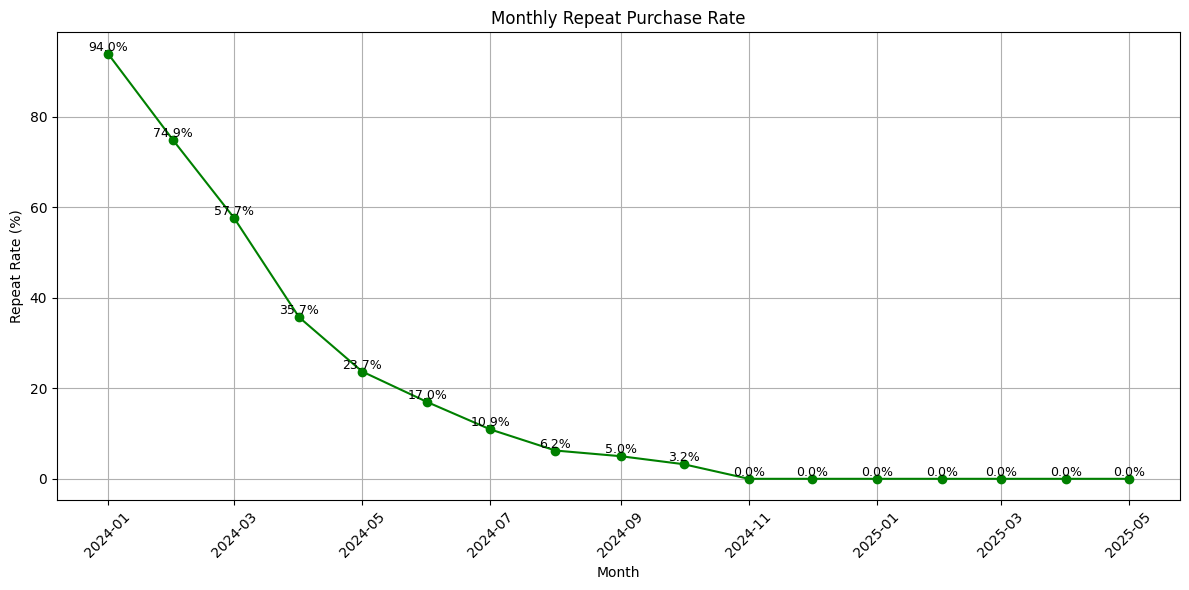

In [ ]:
plt.figure(figsize=(12,6))
ax = plt.plot(repeat_result['month'], repeat_result['repeat_rate_percent'], marker='o', linestyle='-', color='green')

plt.title('Monthly Repeat Purchase Rate')
plt.xlabel('Month')
plt.ylabel('Repeat Rate (%)')
plt.xticks(rotation=45)
plt.grid(True)

# Tambahkan label nilai di setiap titik
for x, y in zip(repeat_result['month'], repeat_result['repeat_rate_percent']):
    plt.text(x, y, f'{y:.1f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

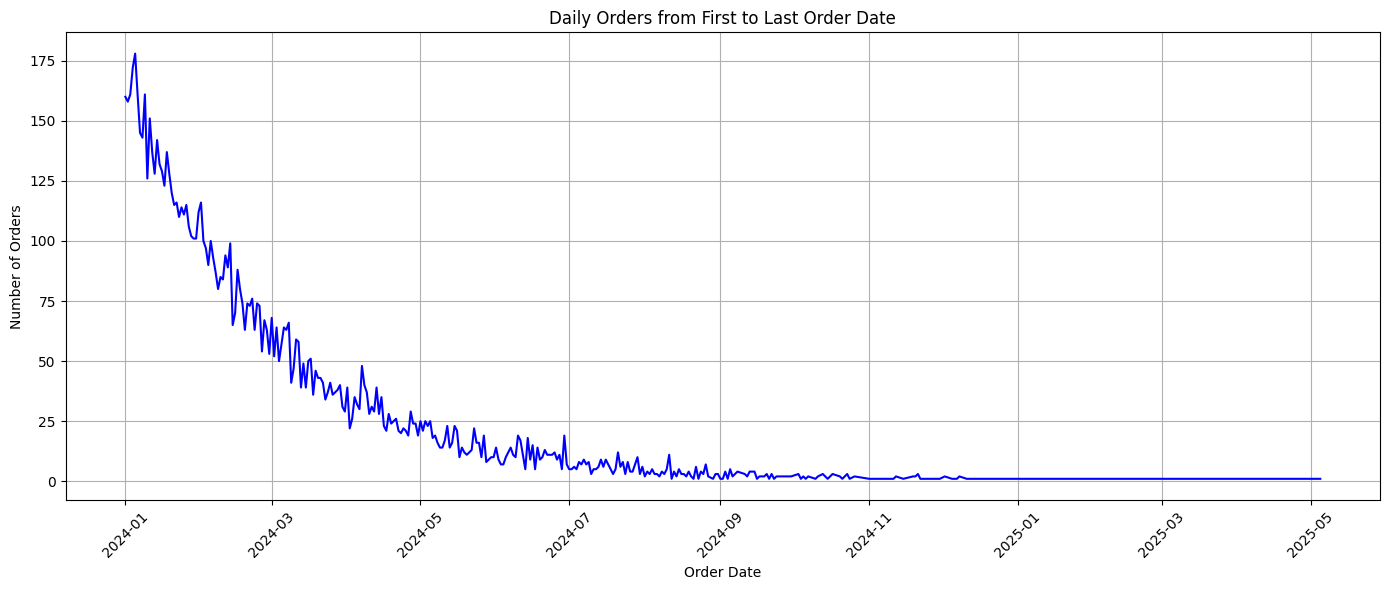

In [ ]:
daily_orders = conn.execute("""
SELECT
  order_date::DATE AS order_day,
  COUNT(order_id) AS total_orders
FROM e_commerce_transactions
GROUP BY order_day
ORDER BY order_day
""").df()

# Visualisasi
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(daily_orders['order_day'], daily_orders['total_orders'], color='blue', linewidth=1.5)
plt.title('Daily Orders from First to Last Order Date')
plt.xlabel('Order Date')
plt.ylabel('Number of Orders')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Anomaly Detection Findings

Sebanyak **457 anomali** terdeteksi pada dataset `e_commerce_transactions`. Seluruh anomali dikategorikan sebagai **`Anomaly_Noise`**, yaitu anomali yang berasal dari kolom `decoy_noise`.

Anomali ini muncul ketika nilai `decoy_noise` melebihi ambang batas ±500. Nilai noise yang terdeteksi berada pada rentang **500.54 hingga 1468.46**, yang menunjukkan kemungkinan data sintetis atau data yang terganggu secara sistematis.

Beberapa anomali juga memiliki nilai `payment_value` yang sangat tinggi, sehingga menunjukkan perilaku pembelian yang tidak biasa. Namun, tidak ditemukan anomali dari nilai `decoy_flag` yang tidak valid.

<H1> Bagian B

## Import Library

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import shap

## EDA & Data Cleaning

In [ ]:
# Load Data
df_credit = pd.read_csv('credit_scoring.csv')
print(df_credit.head(5))

# Check info & null data
print(df_credit.info())
print(df_credit.isnull().sum())

   application_id  age  monthly_income  loan_amount  previous_defaults  \
0          501000   41        13995609      5982664                  0   
1          501001   58        13683833      3711198                  0   
2          501002   33         9417391      7172332                  0   
3          501003   45         6861811      8661056                  0   
4          501004   22         5640742      4520669                  1   

   credit_score  default  leak_col_good  leak_col_subtle  
0           624        0              0           -0.040  
1           809        0              0            0.001  
2           647        0              0            0.077  
3           450        0              0            0.038  
4           816        0              0            0.020  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  

In [ ]:
df_credit = df_credit.drop(['leak_col_good', 'leak_col_subtle'], axis=1)
print(df_credit['default'].value_counts())

default
0    5927
1      73
Name: count, dtype: int64


In [ ]:
# Describe data
print(df_credit.describe())
print(df_credit['default'].value_counts())

       application_id          age  monthly_income   loan_amount  \
count     6000.000000  6000.000000    6.000000e+03  6.000000e+03   
mean    503999.500000    40.321500    1.140386e+07  8.001122e+06   
std       1732.195139    11.300697    4.912598e+06  4.071786e+06   
min     501000.000000    21.000000    3.000310e+06  1.000794e+06   
25%     502499.750000    31.000000    7.163379e+06  4.440939e+06   
50%     503999.500000    41.000000    1.129945e+07  7.982304e+06   
75%     505499.250000    50.000000    1.573705e+07  1.153144e+07   
max     506999.000000    59.000000    1.998622e+07  1.499858e+07   

       previous_defaults  credit_score      default  
count        6000.000000   6000.000000  6000.000000  
mean            0.243667    575.979833     0.012167  
std             0.484767    158.328931     0.109639  
min             0.000000    300.000000     0.000000  
25%             0.000000    438.750000     0.000000  
50%             0.000000    577.500000     0.000000  
75%      

### Data Preparation

In [ ]:
# Feature Engineering
df_credit['dti'] = df_credit['loan_amount'] / (df_credit['monthly_income'] + 1)
df_credit['loan_credit_ratio'] = df_credit['loan_amount'] / (df_credit['credit_score'] + 1)
df_credit['income_per_age'] = df_credit['monthly_income'] / (df_credit['age'] + 1)
df_credit['young_borrower'] = (df_credit['age'] < 25).astype(int)

In [ ]:
# Check Columns
df_credit.columns

Index(['application_id', 'age', 'monthly_income', 'loan_amount',
       'previous_defaults', 'credit_score', 'default', 'dti',
       'loan_credit_ratio', 'income_per_age', 'young_borrower'],
      dtype='object')

In [ ]:
# Feature & Target
X = df_credit.drop(['application_id', 'default'], axis=1)
y = df_credit['default']

# Split data train & test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [ ]:
# Handling imbalance dengan SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", pd.Series(y_train_resampled).value_counts())

Before SMOTE: default
0    4149
1      51
Name: count, dtype: int64
After SMOTE: default
0    4149
1    4149
Name: count, dtype: int64


In [ ]:
# Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

### Modeling

In [ ]:
# Logistic Regression Model
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train_scaled, y_train_resampled)
y_pred_log = logreg.predict(X_test_scaled)
y_proba_log = logreg.predict_proba(X_test_scaled)[:,1]

print("\nLogistic Regression AUC:", roc_auc_score(y_test, y_proba_log))
print(classification_report(y_test, y_pred_log))


Logistic Regression AUC: 0.7321300746497598
              precision    recall  f1-score   support

           0       0.99      0.72      0.84      1778
           1       0.03      0.68      0.06        22

    accuracy                           0.72      1800
   macro avg       0.51      0.70      0.45      1800
weighted avg       0.98      0.72      0.83      1800



In [ ]:
# Gradient Boosting Model
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train_resampled, y_train_resampled)
y_pred_gb = gb.predict(X_test)
y_proba_gb = gb.predict_proba(X_test)[:,1]

print("\nGradient Boosting AUC:", roc_auc_score(y_test, y_proba_gb))
print(classification_report(y_test, y_pred_gb))


Gradient Boosting AUC: 0.6274286736885162
              precision    recall  f1-score   support

           0       0.99      0.86      0.92      1778
           1       0.02      0.23      0.04        22

    accuracy                           0.85      1800
   macro avg       0.50      0.54      0.48      1800
weighted avg       0.98      0.85      0.91      1800



### Feature Importance

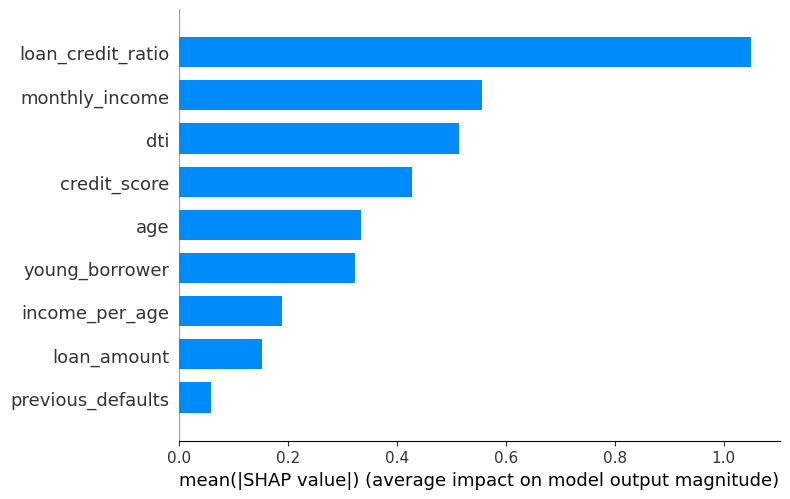

In [ ]:
# SHAP Analysis dengan mmodel Gradient Boosting
explainer_gb = shap.Explainer(gb)
shap_values_gb = explainer_gb(X_test)
shap.summary_plot(shap_values_gb, X_test, plot_type="bar", max_display=10)

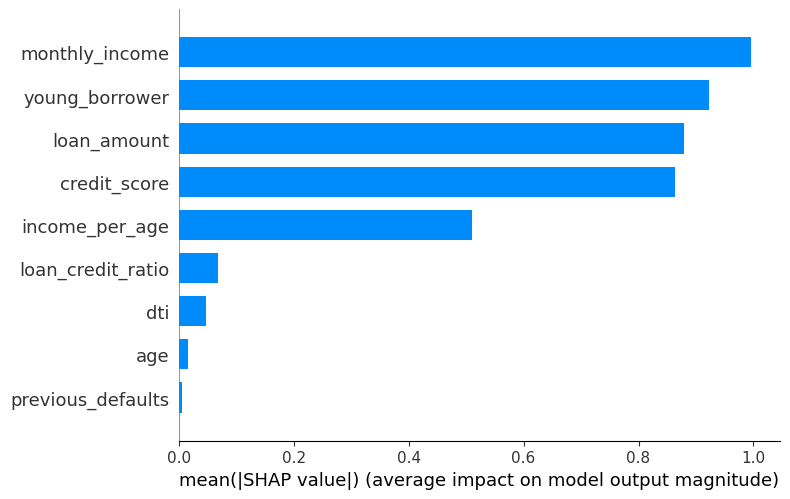

In [ ]:
# SHAP Analysis dengan mmodel Logreg
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns)

explainer_logreg = shap.Explainer(logreg, X_test_scaled_df)
shap_values_logreg = explainer_logreg(X_test_scaled_df)

shap.summary_plot(shap_values_logreg, X_test_scaled_df, plot_type="bar", max_display=10)

In [ ]:
# Scorecard Function
def scorecard(prob, base_score=300, PDO=50):
    factor = PDO / np.log(2)
    offset = base_score - factor * np.log(1/20)
    score = offset - factor * np.log(prob / (1 - prob))
    return np.clip(score, 300, 850)

sample_probs = logreg.predict_proba(X_test_scaled)[:,1]
sample_scores = scorecard(sample_probs)
scorecard_df = pd.DataFrame({
    'Probability of Default': sample_probs[:10],
    'Credit Score': sample_scores[:10]
})

print("\nSample Scorecard Output (Top 10):")
print(scorecard_df.to_string(index=False))

# # 14. Decision Making Slide (Summarized Text)
# decision_text = """
# - Best Model: Logistic Regression (AUC = 0.73) outperforms Gradient Boosting (AUC = 0.62).
# - SMOTE improves minority class detection.
# - SHAP analysis highlights key features (age, monthly_income, loan_amount).
# - Recommend to approve loans with scorecard > 600 (corresponds to lower risk).
# - Potential cost saving: prevent defaults worth IDR 5 million based on score thresholding.
# """
# print(decision_text)


Sample Scorecard Output (Top 10):
 Probability of Default  Credit Score
               0.313140    572.756656
               0.750163    436.785645
               0.000465    850.000000
               0.797459    417.236457
               0.432544    535.679399
               0.108635    667.923093
               0.002376    850.000000
               0.029522    768.038263
               0.272348    586.986137
               0.092123    681.139646


## Simulasi

In [ ]:
# Potensial loss dengan asumsi peminjaman IDR 5 juta per orang
sample_probs = logreg.predict_proba(X_test_scaled)[:, 1]
sample_scores = scorecard(sample_probs)

# Pasang threshold
threshold_score = 600
high_risk_customers = sample_scores < threshold_score
num_high_risk = np.sum(high_risk_customers)
total_customers = len(sample_scores)

print(f"Jumlah nasabah berisiko tinggi (score < {threshold_score}): {num_high_risk} dari {total_customers}")

loan_per_customer = 5_000_000 
potential_total_loss = num_high_risk * loan_per_customer

print(f"Total potensi kerugian jika semua high risk gagal bayar: IDR {potential_total_loss:,}")

# asumsikan hanya 20% yang benar-benar gagal bayar
estimated_default_rate = 0.2 
expected_loss = potential_total_loss * estimated_default_rate

print(f"Estimasi kerugian (dengan asumsi default rate 20%): IDR {expected_loss:,}")

Jumlah nasabah berisiko tinggi (score < 600): 994 dari 1800
Total potensi kerugian jika semua high risk gagal bayar: IDR 4,970,000,000
Estimasi kerugian (dengan asumsi default rate 20%): IDR 994,000,000.0


In [ ]:
# Prediksi Probability dan Scorecard
sample_probs = logreg.predict_proba(X_test_scaled)[:, 1]
sample_scores = scorecard(sample_probs)

# buat dalam bentuk dataframe
results_df = pd.DataFrame({
    'application_id': X_test.index, 
    'prob_default': sample_probs,
    'scorecard': sample_scores,
    'actual_default': y_test.reset_index(drop=True)
})

# simpan ke csv
results_df.to_csv('model_results.csv', index=False)

print(results_df.head())

   application_id  prob_default   scorecard  actual_default
0            1648      0.313140  572.756656               0
1            3967      0.750163  436.785645               0
2            1257      0.000465  850.000000               0
3            3483      0.797459  417.236457               0
4            4474      0.432544  535.679399               0
